# 1. Reminder: Generative models
A generative model is a model that will try to learn the distribution of the data. It can be opposed to discriminative models (classification, ...)

A generative modeling could be, for example, the modelisation of a distribution using gaussian distributions ([credit](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html) to Jake VanderPlas) :

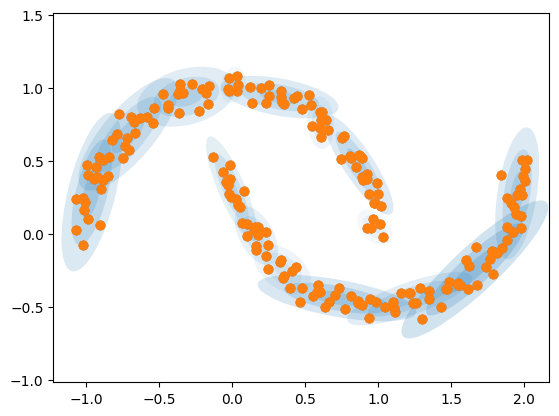

In [28]:
from sklearn.datasets import make_moons
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Ellipse


def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(
            Ellipse(position, width=nsig * width, height=nsig * height, angle=angle, **kwargs)
        )


def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap="viridis", zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis("equal")

    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)


Xmoon, ymoon = make_moons(200, noise=0.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1])

gmm16 = GaussianMixture(n_components=16, random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

Here the mixture of 16 Gaussians serves not to find clusters of data, but rather to model the overall distribution of the input data. 

This is a generative model of the distribution, meaning that the GMM gives us the recipe to generate new random data distributed similarly to our input. 

For example, here are 400 new points drawn from this 16-component GMM fit to our original data:

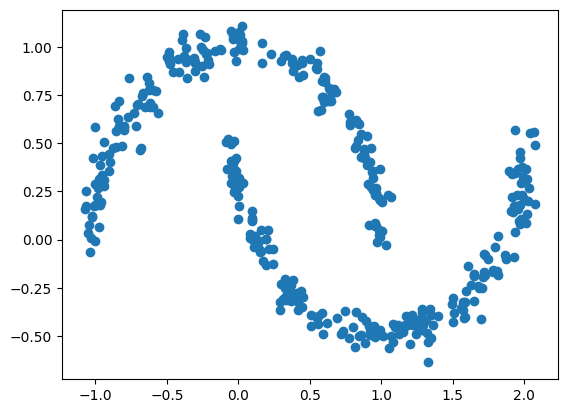

In [29]:
Xnew = gmm16.sample(400)[0]
plt.scatter(Xnew[:, 0], Xnew[:, 1]);

## 2.3. Training a Vanilla AutoEncoder

Let's train a simple AutoEncoder on the MNIST digits dataset!

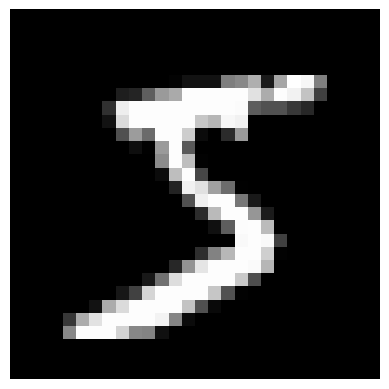

In [30]:
# Import the dataset
import matplotlib.pyplot as plt
import pandas as pd

from keras.datasets import mnist
from keras.utils import to_categorical

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Show an image
plt.imshow(X_train[0], cmap=plt.cm.gray)
plt.axis("off")
plt.show()

In [31]:
import numpy as np

# Normalize the data
X_train = X_train / 255
X_test = X_test / 255

# Reshape the data
n_pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape((len(X_train), n_pixels))
X_test = X_test.reshape((len(X_test), n_pixels))

In [32]:
from keras.layers import Input, Dense
from keras import Model

latent_dim = 32

# define the input layer: the pixel values
input_img = Input(shape=(n_pixels,))

# encode
encoded = Dense(latent_dim, activation="relu")(input_img)

# decode
decoded = Dense(n_pixels, activation="sigmoid")(encoded)

# Define the autoencoder model
autoencoder = Model(input_img, decoded)

In [33]:
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

batch_size = 256

autoencoder.fit(
    X_train, X_train, epochs=10, batch_size=batch_size, validation_data=(X_test, X_test)
)

Epoch 1/10
235/235 [==============================] - 2s 8ms/step - loss: 0.2783 - val_loss: 0.1916
Epoch 2/10
235/235 [==============================] - 2s 8ms/step - loss: 0.1734 - val_loss: 0.1558
Epoch 3/10
235/235 [==============================] - 2s 7ms/step - loss: 0.1465 - val_loss: 0.1348
Epoch 4/10
235/235 [==============================] - 2s 7ms/step - loss: 0.1288 - val_loss: 0.1216
Epoch 5/10
235/235 [==============================] - 2s 7ms/step - loss: 0.1182 - val_loss: 0.1128
Epoch 6/10
235/235 [==============================] - 2s 7ms/step - loss: 0.1110 - val_loss: 0.1066
Epoch 7/10
235/235 [==============================] - 2s 7ms/step - loss: 0.1057 - val_loss: 0.1021
Epoch 8/10
235/235 [==============================] - 2s 7ms/step - loss: 0.1018 - val_loss: 0.0989
Epoch 9/10
235/235 [==============================] - 2s 7ms/step - loss: 0.0991 - val_loss: 0.0966
Epoch 10/10
235/235 [==============================] - 2s 7ms/step - loss: 0.0972 - val_loss: 0.0951

Let's check if it worked!

313/313 [==============================] - 0s 971us/step


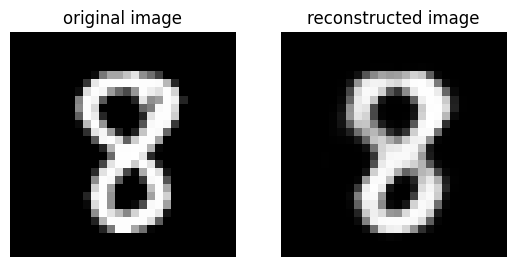

In [34]:
# Get the predictions
X_pred = autoencoder.predict(X_test)

# Show some reconstructed images
idx = np.random.randint(X_test.shape[0])

plt.subplot(121)
plt.imshow(X_test[idx].reshape(28, 28), cmap=plt.cm.gray)
plt.title("original image")
plt.axis("off")
plt.subplot(122)
plt.imshow(X_pred[idx].reshape(28, 28), cmap=plt.cm.gray)
plt.title("reconstructed image")
plt.axis("off")
plt.show()

## 2.4. Latent space

Let's have a look at a part of the latent space now. We need to instantiate a new model using only the encoder part.

In [35]:
# Get the latent variables
encoder = Model(input_img, encoded, name="encoder")
X_encoded = encoder.predict(X_test)
X_encoded.shape

313/313 [==============================] - 0s 946us/step


(10000, 32)

In order to generate new images of digits, we need to know what values in the latent space would generate which digit.

But here the latent space is too messy to control anything!

In many cases, we don't care about controling the latent space, for example :
- image denoising of images
- anomaly detection
- dimensionality reduction

For this kind of application, a classic AutoEncoder is good enough.

But when our application relies on generation of new data, we need control over the latent space we will need a Variational AutoEncoder.

To control the shape of this latent space, we will use a well known shape: a **gaussian distribution**.

# 3. Variational Autoencoder

## 3.1. Latent distribution

When you run an AutoEncoder, you have no idea what the latent distribution will be, as it has absolutely no constraint 

In simple words, your latent variables may look like nothing! But it is always better to have for example a normal distribution: values centered on 0, with a well known standard deviation right?

That's exactly what Variational AutoEncoders (VAEs) do! They force the distribution to follow a given distribution for example a bivariate normal distribution :

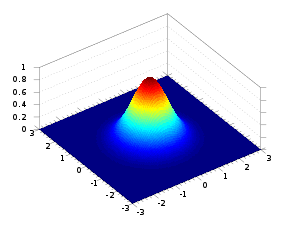

## 3.2. Variational AutoEncoder


In [36]:
import keras
from keras import Model
from keras.layers import Input, Dense, Lambda, Concatenate, Input

import tensorflow as tf

# Redefine the intermediate and latent dimensions
intermediate_dim = 512
latent_dim = 2
batch_size = 128

# Define the encoder part
x = Input(shape=(n_pixels,))
h = Dense(intermediate_dim, activation="relu")(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

Now we have to define the part where z is computed as a function of the mean (z_mean) and standard deviation = np.exp(0.5 * z_log_var).

Because we need to learn the parameters $\mu$ and $\sigma$, we can not directly sample from a normal distribution, with would introduce stochasticity and the impossibility to compute a gradient of error with respect to the parameters.

We thus use the "reparameterization trick" by separating the deterministic and the stochastic parts of the sampling operation. Instead of directly sampling from the distribution N($\mu$,$\sigma^2$), we sample $\epsilon$ from a standard Normal distribution $\mathcal{N}(0, 1)$, and compute the desired sample z as : 

$z = \mu + \sigma * \epsilon$

In [37]:
class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


# Define the encoded z layer
z = Sampling()([z_mean, z_log_var])

Finally, we define the decoder part and the VAE model:

In [38]:
# Here is the decoder part
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")

# Define the decoder part
latent_inputs = Input(shape=(latent_dim,))

h2 = Dense(intermediate_dim, activation="relu")(latent_inputs)
decoder_outputs = Dense(n_pixels, activation="sigmoid")(h2)

decoder = Model(latent_inputs, decoder_outputs, name="decoder")

In [39]:
X_train.shape

(60000, 784)

## 3.3. Training: the KL loss

We need to add a specific loss: indeed we do not only have to compute the difference between the input and output image, we also want to ensure a gaussian distribution for z (the Kullback-Leibler loss).

Below we implement reconstruction and KL loss combination by subclassing `keras.Model`.

In [40]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)

        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)

        # Add reconstruction loss
        reconstruction_loss = tf.reduce_mean(
            keras.losses.mean_squared_error(inputs, reconstruction)
        )
        reconstruction_loss *= 28 * 28
        self.add_loss(reconstruction_loss)

        # Keep track of all the loses
        total_loss = reconstruction_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return reconstruction


batch_size = 128
epochs = 10
optimizer = keras.optimizers.Adam()

vae = VAE(encoder, decoder)
vae.compile(optimizer=optimizer)

vae.fit(x=X_train, y=X_train, epochs=epochs, batch_size=batch_size)

Epoch 1/10
469/469 [==============================] - 6s 12ms/step - total_loss: 49.9571 - reconstruction_loss: 47.0772 - kl_loss: 2.8799
Epoch 2/10
469/469 [==============================] - 5s 11ms/step - total_loss: 41.6516 - reconstruction_loss: 39.6465 - kl_loss: 2.0051
Epoch 3/10
469/469 [==============================] - 5s 11ms/step - total_loss: 40.1619 - reconstruction_loss: 38.0003 - kl_loss: 2.1616
Epoch 4/10
469/469 [==============================] - 5s 10ms/step - total_loss: 39.2476 - reconstruction_loss: 36.9803 - kl_loss: 2.2673
Epoch 5/10
469/469 [==============================] - 4s 10ms/step - total_loss: 38.6215 - reconstruction_loss: 36.2782 - kl_loss: 2.3433
Epoch 6/10
469/469 [==============================] - 5s 10ms/step - total_loss: 38.1416 - reconstruction_loss: 35.7394 - kl_loss: 2.4023
Epoch 7/10
469/469 [==============================] - 5s 11ms/step - total_loss: 37.7376 - reconstruction_loss: 35.2834 - kl_loss: 2.4543
Epoch 8/10
469/469 [==============

## 3.4. Latent space

Let's have a look at the latent variables!


In [41]:
# Get the predictions
X_encoded = encoder.predict(X_test)[2]

# Show activation in the latent space
###plot_latent_space_weights(X_encoded[:, :2]).show()

313/313 [==============================] - 2s 5ms/step


## 3.5. Generating new samples

We can now generate new samples: Can you tell me how I can generate a plausible 0 digit ? 


In [42]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_19 (Dense)            (None, 512)               1536      
                                                                 
 dense_20 (Dense)            (None, 784)               402192    
                                                                 
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


1/1 [==============================] - 0s 56ms/step


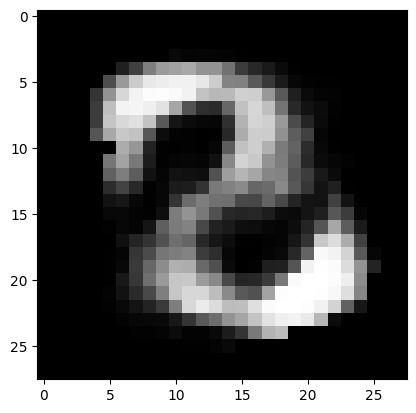

In [43]:
z_sample = np.array([[-2, 2]])

generated_x = decoder.predict(z_sample)

plt.imshow(generated_x.reshape(28, 28), cmap=plt.cm.gray)
plt.show()

We can sample through the whole latent space and display generated digits!

1/1 [==============================] - 0s 16ms/step


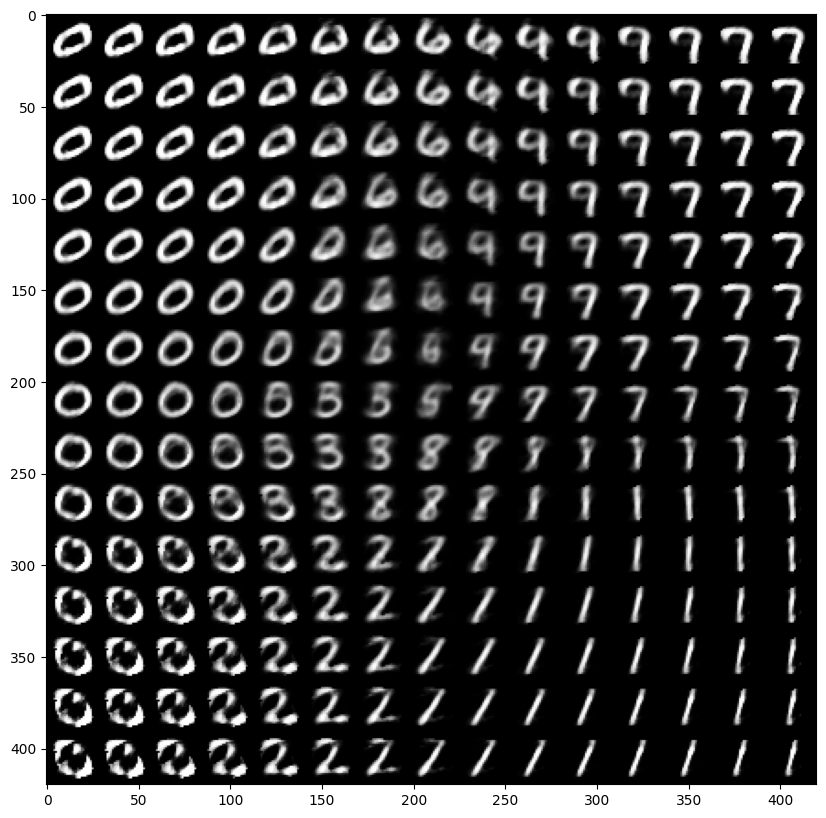

In [44]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap=plt.cm.gray)
plt.show()

## 4.3. Implementing a Conditional Variational AutoEncoder

The implementation is almost the same as the VAE, there is one slight difference: the part where we add the target value.

In [45]:
# conditional
n_classes = 10
label = Input(shape=(n_classes,))
zc = Concatenate()([z, label])
encoder = Model([x, label], [z_mean, z_log_var, zc], name="encoder")

In [46]:
# Generate decoder
latent_inputs = Input(shape=(latent_dim + n_classes,))

h2 = Dense(intermediate_dim, activation="relu")(latent_inputs)
decoder_outputs = Dense(n_pixels, activation="sigmoid")(h2)

decoder = Model(latent_inputs, decoder_outputs, name="decoder")

Below we write our own training procedure by subclassing `keras.Model` and writing our own `train_step` function which will be called repeatedly by the `fit` method.

In [47]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(keras.losses.mean_squared_error(y, reconstruction))

            reconstruction_loss *= 64 * 64
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [33]:
batch_size = 128
epochs = 30
optimizer = keras.optimizers.Adam()

vae = VAE(encoder, decoder)
vae.compile(optimizer=optimizer)

vae.fit(x=[X_train, y_train], y=X_train, epochs=epochs, batch_size=batch_size)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - kl_loss: 6.2510 - loss: 227.5679 - reconstruction_loss: 221.3169
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - kl_loss: 3.9119 - loss: 171.4436 - reconstruction_loss: 167.5317
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - kl_loss: 3.6504 - loss: 161.4626 - reconstruction_loss: 157.8122
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - kl_loss: 3.5482 - loss: 156.3465 - reconstruction_loss: 152.7983
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - kl_loss: 3.4946 - loss: 152.9077 - reconstruction_loss: 149.4132
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - kl_loss: 3.4466 - loss: 150.4505 - reconstruction_loss: 147.0040
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - kl_loss: 3.4164 - loss: 148.5723 - reconstruction_loss: 145.1559
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - kl_loss: 3.3915 - loss: 147.1558 - reconstruction_loss: 143.7642
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━

## 4.4. Generating new images

Now we can generate new samples of the desired digit, let's try out!


In [ ]:
# Choose the digit to generate
digit_to_generate = 5

# Convert it to categorical
val = to_categorical(digit_to_generate, num_classes=n_classes)

# Create the input vector (latent value and digit class)
input_vector = np.zeros((1, latent_dim + n_classes))
input_vector[0, latent_dim:] = val

# Generate the output
generated_x = decoder.predict(input_vector)

# Display the output
plt.imshow(generated_x.reshape(28, 28), cmap=plt.cm.gray)
plt.axis("off")
plt.show()

If we now want to explore more latent possibilities, we just have to change the values :

In [ ]:
# display a 2D manifold of the digits
n = 9  # figure with 9x9 digits
digit_size = 28

figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-0.5, 0.5, n)
grid_y = np.linspace(-0.5, 0.5, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        # Create the input vector (latent value and digit class)
        input_vector = np.zeros((1, latent_dim + n_classes))
        input_vector[0, latent_dim:] = val
        input_vector[0, 0] = xi
        input_vector[0, 1] = yi

        generated_x = decoder.predict(input_vector)
        digit = generated_x[0].reshape(digit_size, digit_size)
        figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap=plt.cm.gray)
plt.axis("off")
plt.show()